In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://www.csc.kth.se/cvap/actions/boxing.zip
!wget http://www.csc.kth.se/cvap/actions/handclapping.zip
!wget http://www.csc.kth.se/cvap/actions/handwaving.zip
!wget http://www.csc.kth.se/cvap/actions/jogging.zip
!wget http://www.csc.kth.se/cvap/actions/running.zip
!wget http://www.csc.kth.se/cvap/actions/walking.zip

!unzip boxing.zip -d boxing
!unzip handclapping.zip -d handclapping
!unzip handwaving.zip -d handwaving
!unzip jogging.zip -d jogging
!unzip running.zip -d running
!unzip walking.zip -d walking

!rm *.zip

--2022-10-10 05:04:15--  http://www.csc.kth.se/cvap/actions/boxing.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/boxing.zip [following]
--2022-10-10 05:04:15--  https://www.csc.kth.se/cvap/actions/boxing.zip
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194498294 (185M) [application/zip]
Saving to: ‘boxing.zip’

boxing.zip            1%[                    ]   3.21M  1.02MB/s    eta 2m 58s ^C
--2022-10-10 05:04:19--  http://www.csc.kth.se/cvap/actions/handclapping.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301

In [ ]:
import imageio
import cv2
import numpy as np
import pandas as pd
import os
import pickle
import re
import cv2
from PIL import Image

CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]

In [ ]:
def parse_sequence_file():
    # print("Parsing ../dataset/00sequences.txt")

    # Read 00sequences.txt file.
    with open('/content/drive/MyDrive/atm/00sequences.txt', 'r') as content_file:
        content = content_file.read()

    # Replace tab and newline character with space, then split file's content
    # into strings.
    content = re.sub("[\t\n]", " ", content).split()

    # Dictionary to keep ranges of frames with humans.
    # Example:
    # video "person01_boxing_d1": [(1, 95), (96, 185), (186, 245), (246, 360)].
    frames_idx = {}

    # Current video that we are parsing.
    current_filename = ""

    for s in content:
        if s == "frames":
            # Ignore this token.
            continue
        elif s.find("-") >= 0:
            # This is the token we are looking for. e.g. 1-95.
            if s[len(s) - 1] == ',':
                # Remove comma.
                s = s[:-1]

            # Split into 2 numbers => [1, 95]
            idx = s.split("-")

            # Add to dictionary.
            if not current_filename in frames_idx:
                frames_idx[current_filename] = []
            frames_idx[current_filename].append((int(idx[0]), int(idx[1])))
        else:
            # Parse next file.
            current_filename = s + "_uncomp.avi"

    return frames_idx


## Extracting Spatio temporal features from videos

In [ ]:
pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def make_raw_dataset(dataset="train"):

    frames_idx = parse_sequence_file()

    data = []

    for category in CATEGORIES:
        # Get all files in current category's folder.
        folder_path =  category
        filenames = sorted(os.listdir(folder_path))
        
        for filename in filenames:
            
            filepath = os.path.join( category, filename)
            #print(filepath)
            # Get id of person in this video.
            person_id = int(filename.split("_")[0][6:])

            vid = imageio.get_reader(filepath, "ffmpeg")

            frames = []

            # Add each frame to correct list.
            for i, frame in enumerate(vid):
                # Boolean flag to check if current frame contains human.
                ok = False
                for seg in frames_idx[filename]:
                    if i >= seg[0] and i <= seg[1]:
                        ok = True
                        break
                if not ok:
                    continue

                # Convert to grayscale.
                frame = Image.fromarray(np.array(frame))
                frame = frame.convert("L")
                frame = np.array(frame.getdata(),
                                 dtype=np.float32).reshape((120, 160))
                frame = np.array(Image.fromarray(frame).resize((12, 32)))

                frames.append(frame)

            data.append({
                "filename": filename,
                "category": category,
                "frames": frames    
            })

    pickle.dump(data, open("drive/MyDrive/atm/%s.p" % dataset, "wb"))

make_raw_dataset(dataset="train")

FileNotFoundError: ignored

In [ ]:
train = pickle.load(open("drive/MyDrive/atm/train.p", "rb"))

In [ ]:
train_fea = []
for i in train:
    for j in i["frames"]:
        train_fea.append(j)

train_fea = np.array(train_fea).reshape(-1,384)
print(train_fea.shape)

from sklearn.preprocessing import minmax_scale
train_fea = minmax_scale(train_fea-train_fea.mean(), feature_range=(-1,1))

train_fea = pd.DataFrame(train_fea[:74481])


(74672, 384)


## Extracting Optical flow Features from videos

In [ ]:
def make_optflow_dataset(dataset="train"):

    # Setup parameters for optical flow.
    farneback_params = dict(
        winsize=20, iterations=1,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN, levels=1,
        pyr_scale=0.5, poly_n=5, poly_sigma=1.1, flow=None)

    frames_idx = parse_sequence_file()

    data = []

    for category in CATEGORIES:
        # Get all files in current category's folder.
        folder_path = category
        filenames = sorted(os.listdir(folder_path))

        for filename in filenames:
            filepath = os.path.join( category, filename)

            # Get id of person in this video.
            person_id = int(filename.split("_")[0][6:])

            vid = imageio.get_reader(filepath, "ffmpeg")

            flow_x = []
            flow_y = []

            prev_frame = None
            # Add each frame to correct list.
            for i, frame in enumerate(vid):
                # Boolean flag to check if current frame contains human.
                ok = False
                for seg in frames_idx[filename]:
                    if i >= seg[0] and i <= seg[1]:
                        ok = True
                        break
                if not ok:
                    continue
                
                # Convert to grayscale.
                frames = Image.fromarray(np.array(frame))
                frames = frames.convert("L")
                frames = np.array(frames.getdata(),
                                 dtype=np.float32).reshape((120, 160))
                frames = np.array(Image.fromarray(frames).resize((60, 80)))
                #print(frame.shape[1])
                #print(frame.shape[0])
                if prev_frame is not None:
                    # Calculate optical flow.
                    flows = cv2.calcOpticalFlowFarneback(prev_frame, frames, **farneback_params)
                    
                    
                    subsampled_x = np.zeros((32, 12), dtype=np.float32)
                    subsampled_y = np.zeros((32, 12), dtype=np.float32)
                    # print(subsampled_x)
                    for r in range(32):
                        for c in range(12):
                            subsampled_x[r, c] = flows[r*2, c*2, 0]
                            subsampled_y[r, c] = flows[r*2, c*2, 1]
                              
                    flow_x.append(subsampled_x)
                    flow_y.append(subsampled_y)

                prev_frame = frames

            data.append({
                "filename": filename,
                "category": category,
                "flow_x": flow_x,
                "flow_y": flow_y    
            })

    pickle.dump(data, open("drive/MyDrive/atm/%s_flow.p" % dataset, "wb"))

make_optflow_dataset(dataset="train")

FileNotFoundError: ignored

In [ ]:
train_flow = pickle.load(open("drive/MyDrive/atm/train_flow.p", "rb"))

In [ ]:
train_flowx_fea = []
for i in train_flow:
    for j in i["flow_x"]:
        train_flowx_fea.append(j)

train_flowx_fea = np.array(train_flowx_fea).reshape(-1,384)
print(train_flowx_fea.shape)
# train_flowx_fea = minmax_scale(train_flowx_fea-train_flowx_fea.mean(), feature_range=(-1,1))
train_flowx_fea = pd.DataFrame(train_flowx_fea)


train_flowy_fea = []
for i in train_flow:
    for j in i["flow_y"]:
        train_flowy_fea.append(j)

train_flowy_fea = np.array(train_flowy_fea).reshape(-1,384)
print(train_flowy_fea.shape)
# train_flowy_fea = minmax_scale(train_flowy_fea-train_flowy_fea.mean(), feature_range=(-1,1))
train_flowy_fea = pd.DataFrame(train_flowy_fea)


(74481, 384)
(74481, 384)


In [ ]:
df = pd.concat([train_fea, train_flowx_fea, train_flowy_fea], axis=1, ignore_index=True)

In [ ]:
box = list(range(15027))
cla = list(range(15027, 28128))
wav = list(range(28128, 44542))
jog = list(range(44542, 53420))
run = list(range(53420, 59726))
wal = list(range(59726, 74481))

df.loc[box,'label'] = 0
df.loc[cla,'label'] = 1
df.loc[wav,'label'] = 2
df.loc[jog,'label'] = 3
df.loc[run,'label'] = 4
df.loc[wal,'label'] = 5

In [ ]:
# filling nan values
df = df.fillna(0)

In [ ]:
X = df.iloc[:, :-1]
Y = df.iloc[:,-1]

from keras.utils import np_utils
Y = np_utils.to_categorical(Y)

print(X.shape)
print(Y.shape)

(74481, 1152)
(74481, 6)


### Triple stacked autoencoders

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.python.keras import regularizers

batch_size = 16
input_dim = 1152 #num of predictor variables
learning_rate = 1e-5
input_layer = Input(shape=(input_dim, ), name="input")
#Input Layer
encoder = Dense (1000, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)

# Output Layer
decoder = Dense(input_dim, activation="sigmoid", activity_regularizer=regularizers.l1(learning_rate))(encoder)

autoencoder_1 = Model(inputs=input_layer, outputs=decoder)
autoencoder_1.compile(loss='mean_squared_error',optimizer='adam')
stack_1 = autoencoder_1.fit(X, X,epochs=5,batch_size=batch_size)

autoencoder_2_input = autoencoder_1.predict(X)
autoencoder_2_input = np.concatenate((autoencoder_2_input , X))

autoencoder_2 = Model(inputs=input_layer, outputs=decoder)
autoencoder_2.compile(loss='mean_squared_error',optimizer='adam')
stack_2 = autoencoder_2.fit(autoencoder_2_input, autoencoder_2_input,epochs=5,batch_size=32)

autoencoder_3_input = autoencoder_2.predict(autoencoder_2_input)
autoencoder_3_input = np.concatenate((autoencoder_3_input, autoencoder_2_input))\

autoencoder_3 = Model(inputs=input_layer, outputs=decoder)
autoencoder_3.compile(loss='mean_squared_error', optimizer='adam')
stack_3 = autoencoder_3.fit(autoencoder_3_input, autoencoder_3_input, epochs=5, batch_size=64)


Epoch 1/5
4656/4656 [==============================] - 42s 9ms/step - loss: 0.0862
Epoch 2/5
4656/4656 [==============================] - 42s 9ms/step - loss: 0.0817
Epoch 3/5
4656/4656 [==============================] - 42s 9ms/step - loss: 0.0809
Epoch 4/5
4656/4656 [==============================] - 42s 9ms/step - loss: 0.0805
Epoch 5/5
4656/4656 [==============================] - 43s 9ms/step - loss: 0.0803
Epoch 1/5
4656/4656 [==============================] - 56s 12ms/step - loss: 0.0421
Epoch 2/5
4656/4656 [==============================] - 56s 12ms/step - loss: 0.0418
Epoch 3/5
4656/4656 [==============================] - 56s 12ms/step - loss: 0.0417
Epoch 4/5
4656/4656 [==============================] - 57s 12ms/step - loss: 0.0416
Epoch 5/5
4656/4656 [==============================] - 59s 13ms/step - loss: 0.0415
Epoch 1/5
4656/4656 [==============================] - 79s 17ms/step - loss: 0.0223
Epoch 2/5
4656/4656 [==============================] - 79s 17ms/step - loss: 0.02

### Make BoW vector for every video frame

In [ ]:
import argparse
import numpy as np
import os
import pickle

from scipy.cluster.vq import vq

def make_bow(dataset, clusters, tfidf):
    print("Make bow vector for each frame")

    # Count total number of frames.
    n_frames = len(dataset)

    # Init bow vectors for all frames.
    bow = np.zeros((n_frames, clusters.shape[1]), dtype=np.float)

    # Check whether to use TF-IDF weighting.
    if tfidf:
        print("Applying TF-IDF weighting")
        freq = np.sum((bow > 0) * 1, axis = 0)
        idf = np.log((n_frames + 1) / (freq + 1))
        bow = dataset * idf

    return bow

if __name__ == "__main__":

    tfidf = 1
    clus = autoencoder_3.predict(X)
    
    # Load clusters.
    clusters = clus

    # Load dataset.
    dataset = clus

    # Make bow vectors.
    dataset_bow = make_bow(dataset, clusters, tfidf)


Make bow vector for each frame


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


Applying TF-IDF weighting


### VGG

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
from sklearn.model_selection import train_test_split
(X_train, X_test, Y_train, Y_test) = train_test_split(dataset_bow, Y,
	test_size=0.20, random_state=42)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Flatten, Bidirectional, LSTM, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend as K
from keras.models import load_model

In [ ]:
def Conv_1D_Block(x, model_width, kernel):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(model_width, kernel, padding='same', kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

class VGG:
    def __init__(self, length, num_channel, num_filters, problem_type='Regression', output_nums=1, dropout_rate=False):
        self.length = length
        self.num_channel = num_channel
        self.num_filters = num_filters
        self.problem_type = problem_type
        self.output_nums = output_nums
        self.dropout_rate = dropout_rate

    def VGG19(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(2500, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model

model = VGG(length=1152, num_channel=1, num_filters=16, problem_type="Classification", output_nums=6, dropout_rate=0.3).VGG19()

from keras.callbacks import ModelCheckpoint, EarlyStopping
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=3, verbose=1, mode='auto')
checkpoint_filepath="/content/drive/MyDrive/atm/vgg19_weight/vgg19.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [ ]:
import time
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=["accuracy"])
start = time.time()
hist = model.fit(X_train, Y_train, batch_size=40, epochs=20, verbose=1, validation_data=(X_test, Y_test), callbacks=[checkpoint, early])
model.save(checkpoint_filepath)
print('Training Time:%.2fsec' % float(time.time()-start))

Epoch 1/20
1490/1490 [==============================] - ETA: 0s - loss: 0.7545 - accuracy: 0.6962
Epoch 1: val_accuracy improved from -inf to 0.75767, saving model to /content/drive/MyDrive/atm/vgg19_weight/vgg19.h5
1490/1490 [==============================] - 614s 379ms/step - loss: 0.7545 - accuracy: 0.6962 - val_loss: 0.5728 - val_accuracy: 0.7577
Epoch 2/20
1490/1490 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.7773
Epoch 2: val_accuracy improved from 0.75767 to 0.79070, saving model to /content/drive/MyDrive/atm/vgg19_weight/vgg19.h5
1490/1490 [==============================] - 582s 390ms/step - loss: 0.5319 - accuracy: 0.7773 - val_loss: 0.5156 - val_accuracy: 0.7907
Epoch 3/20
1490/1490 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.8143
Epoch 3: val_accuracy improved from 0.79070 to 0.80358, saving model to /content/drive/MyDrive/atm/vgg19_weight/vgg19.h5
1490/1490 [==============================] - 571s 383ms/step - loss: 0.4

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/atm/vgg19_weight/vgg19_1.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.compile(loss='categorical_crossentropy', optimizer=SGD(0.0001), metrics=["accuracy"])
start = time.time()
hist = model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_test, Y_test), callbacks=[checkpoint])
print('Training Time:%.2fsec' % float(time.time()-start))
model.save(checkpoint_filepath)

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report
Y_pred = model.predict(X_test)
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking']))

              precision    recall  f1-score   support

      boxing       0.97      0.98      0.98      2921
handclapping       0.99      0.99      0.99       968
  handwaving       0.99      0.99      0.99      1028
     jogging       0.82      0.80      0.81       878
     running       0.86      0.75      0.80       668
     walking       0.88      0.93      0.91       986

    accuracy                           0.94      7449
   macro avg       0.92      0.91      0.91      7449
weighted avg       0.94      0.94      0.94      7449



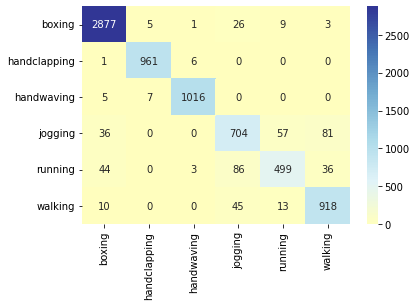

In [ ]:
# Compute the error.
from sklearn.metrics import confusion_matrix
import seaborn as sns
classNames = ['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking']
Y_pred = model.predict(X_test)
CM = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
# drawing confusion matrix
sns.heatmap(CM, center = True , annot=True, fmt="d" ,cmap="RdYlBu", xticklabels=classNames, yticklabels=classNames)

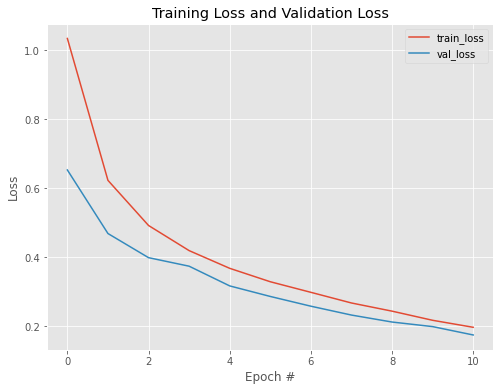

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, 11), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, 11), hist.history["val_loss"], label="val_loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss.png")
plt.show()

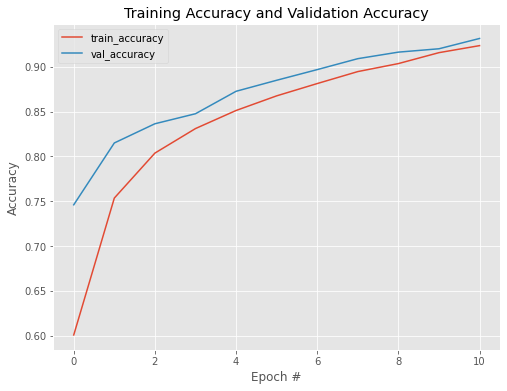

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, 11), hist.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 11), hist.history["val_accuracy"], label="val_accuracy")
plt.title("Training Accuracy and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy.png")
plt.show()

### Prediction

In [ ]:
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

filepath = "/content/handwaving/person18_handwaving_d4_uncomp.avi"

filename = filepath.split('/')[-1]
vid = imageio.get_reader(filepath, "ffmpeg")

frames = []
data = []

frames_idx = parse_sequence_file()

# Add each frame to correct list.
for i, frame in enumerate(vid):
    # Boolean flag to check if current frame contains human.
    ok = False
    for seg in frames_idx[filename]:
        if i >= seg[0] and i <= seg[1]:
            ok = True
            break
    if not ok:
        continue

    # Convert to grayscale.
                
    frame = Image.fromarray(np.array(frame))
    frame = frame.convert("L")
    frame = np.array(frame.getdata(),
                     dtype=np.float32).reshape((120, 160))
    frame = np.array(Image.fromarray(frame).resize((12, 32)))

    frames.append(frame)

data.append({
    "frames": frames    
})

fea = []
for i in data:
    for j in i["frames"]:
        fea.append(j)

fea = np.array(fea).reshape(-1,384)
# print(fea.shape)

from sklearn.preprocessing import minmax_scale
fea = minmax_scale(fea-fea.mean(), feature_range=(-1,1))
fea = pd.DataFrame(fea)

vid = imageio.get_reader(filepath, "ffmpeg")

flow_x = []
flow_y = []
data = []
prev_frame = None

# Setup parameters for optical flow.
farneback_params = dict(
    winsize=20, iterations=1,
    flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN, levels=1,
    pyr_scale=0.5, poly_n=5, poly_sigma=1.1, flow=None)

# Add each frame to correct list.
for i, frame in enumerate(vid):
    # Boolean flag to check if current frame contains human.
    ok = False
    for seg in frames_idx[filename]:
        if i >= seg[0] and i <= seg[1]:
            ok = True
            break
    if not ok:
        continue
                
    # Convert to grayscale.
    frames = Image.fromarray(np.array(frame))
    frames = frames.convert("L")
    frames = np.array(frames.getdata(),
                        dtype=np.float32).reshape((120, 160))
    frames = np.array(Image.fromarray(frames).resize((60, 80)))
    if prev_frame is not None:
        # Calculate optical flow.
        flows = cv2.calcOpticalFlowFarneback(prev_frame, frames, **farneback_params)
            
            
        subsampled_x = np.zeros((32, 12), dtype=np.float32)
        subsampled_y = np.zeros((32, 12), dtype=np.float32)
        # print(subsampled_x)
        for r in range(32):
            for c in range(12):
                subsampled_x[r, c] = flows[r*2, c*2, 0]
                subsampled_y[r, c] = flows[r*2, c*2, 1]
                        
        flow_x.append(subsampled_x)
        flow_y.append(subsampled_y)

    prev_frame = frames

data.append({
    "filename": filename,
    "flow_x": flow_x,
    "flow_y": flow_y    
})


flowx= []
for i in data:
    for j in i["flow_x"]:
        flowx.append(j)

flowx = np.array(flowx).reshape(-1,384)
# print(flowx.shape)
flowx = pd.DataFrame(flowx)

flowy = []
for i in data:
    for j in i["flow_y"]:
        flowy.append(j)

flowy = np.array(flowy).reshape(-1,384)
# print(flowy.shape)
flowy = pd.DataFrame(flowy)

features = pd.concat([fea, flowx, flowy], axis=1, ignore_index=True)
# filling nan values
features = features.fillna(0)

import argparse
import numpy as np
import os
import pickle

from scipy.cluster.vq import vq

def make_bow(dataset, clusters, tfidf):
    # print("Make bow vector for each frame")

    # Count total number of frames.
    n_frames = len(dataset)

    # Init bow vectors for all frames.
    bow = np.zeros((n_frames, clusters.shape[1]), dtype=np.float)


    # Check whether to use TF-IDF weighting.
    if tfidf:
        # print("Applying TF-IDF weighting")
        freq = np.sum((bow > 0) * 1, axis = 0)
        idf = np.log((n_frames + 1) / (freq + 1))
        bow = dataset * idf

    return bow

if __name__ == "__main__":

    tfidf = 1

    # Load clusters.
    clusters = features

    # Load dataset.
    dataset = features

    # Make bow vectors.
    dataset_bow = make_bow(dataset, clusters, tfidf)


class_names = ["boxing", "handclapping", "handwaving", "jogging", "running",  "walking"]

# load trained model
model = load_model('vgg19.h5')
pred = model.predict(dataset_bow)
x = []
for i in pred:
    x.append(np.argmax(i))

most_common_item = max(x, key = x.count)

print('Action:',class_names[most_common_item])